In [1]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from sklearn.linear_model import LinearRegression, RidgeCV
from lib import Model, Humanizer, Plotter, ExperimentInfo
from lib.wikipedia import DataFrameBuilder
from mynotebook import *

In [79]:
exp_info = ExperimentInfo(ExperimentInfo.SS2, threads=2, block_size=128 * 1024**2)
df_builder = DataFrameBuilder(threads=exp_info.threads)

prof_ss2_out = df_builder.get_strong_scaling_df(2)
prof_ss1_out = df_builder.get_strong_scaling_df(1)
prof_1vm_out = df_builder.get_1VM_df()
target_out = df_builder.get_target_df()

target = remove_outliers(target_out)
prof_ss2 = remove_outliers(prof_ss2_out)
prof_1vm = remove_outliers(prof_1vm_out)
prof_ss1 = remove_outliers(prof_ss1_out)

In [376]:
import numpy as np


def get_iterations_by_blocks(inputs, threads, block_size):
    tasks = np.ceil(inputs / block_size)
    first = (tasks > 0).astype('int')
    nonfirst = np.ceil((tasks - threads) / threads).astype('int')
    nonfirst[nonfirst < 0] = 0
    return first, nonfirst

def get_iterations_by_n_tasks(threads, tasks):
    first = [1] * len(threads)
    nonfirst = np.ceil((tasks - threads) / threads).astype('int')
    nonfirst[nonfirst < 0] = 0
    return first, nonfirst

def get_extra_df(df, exp_info):
    extra = pd.DataFrame()
    extra['workers'] = df.workers               # best for target, prof **
    #extra['log_workers'] = np.log2(df.workers)  # best for target, prof **
    #extra['input'] = df.input                   # best for target
    #extra['log_input'] = np.log2(df.input)      # second best for target, prof **
    #extra['input_per_worker'] = df.input / df.workers
    #extra['log_input_per_worker'] = np.log2(df.input / df.workers)  # best for prof
    threads = df.workers * exp_info.threads
    _, extra['iters_stg0_nf'] = get_iterations_by_blocks(df.input,
                                                                             threads,
                                                                             exp_info.block_size)
    _, extra['iters_stg1_nf'] = get_iterations_by_n_tasks(threads, 200)
    
    extra['ms'] = df.ms
    return extra

In [386]:
# With logs, results are better

prof = pd.concat([prof_1vm, prof_ss1[prof_ss1.workers != 2], prof_ss2[prof_ss2.workers == 2]])  # total: 0.0901, max: 0.1848
#prof = pd.concat([prof_1vm, prof_ss1[prof_ss1.workers == 1], prof_ss2[prof_ss2.workers == 2]])  # total: 0.1512, max: 0.2987
#prof = pd.concat([prof_1vm, prof_ss1, prof_ss2[prof_ss2.workers == 2]])  # total: 0.1041, max: 0.2351
#prof = pd.concat([prof_1vm, prof_ss1, prof_ss2])  # total: 0.1137, max: 0.2153
#prof = prof_ss1  # total: 0.1129, max: 0.2957
#prof = pd.concat([prof_1vm, prof_ss1])  # total: 0.1214, max: 0.3019
#prof = prof_1vm  # total: 0.1560, max: 0.3070
#prof = prof_ss2  # crap
#prof = pd.concat([prof_1vm, prof_ss2])  # crap
#prof = pd.concat([prof_1vm, prof_ss1[prof_ss1.workers <= 2]])  # total: 0.1539, max: 0.3034
#prof = pd.concat([prof_1vm, prof_ss1, prof_ss2[prof_ss2.workers == 3]])  # total: 0.1665, max: 0.4290

,workers,iters_stg0_nf,iters_stg1_nf,ms
0,1,0,99,20442.10
1,1,0,99,20010.50
2,1,1,99,23701.30
3,1,3,99,29994.68
4,2,1,49,23622.50
5,4,0,24,20853.50


,workers,iters_stg0_nf,iters_stg1_nf
0,4,45,24
31,8,22,12
61,16,11,6
91,32,5,3
121,64,2,1


19567.042619883076

array([  296.30073099,  3256.12807018,     4.21893567])

[0.005024820013853951,
 (1, 0.007537230020779687),
 (2, 7.700240887060457e-16),
 (4, 4.186898667859165e-15)]

[0.09512356915687441,
 (4, 0.09129344994064988),
 (8, 0.09373781454607508),
 (16, 0.06847190424723225),
 (32, 0.0333416587697758),
 (64, 0.1855915115732953)]

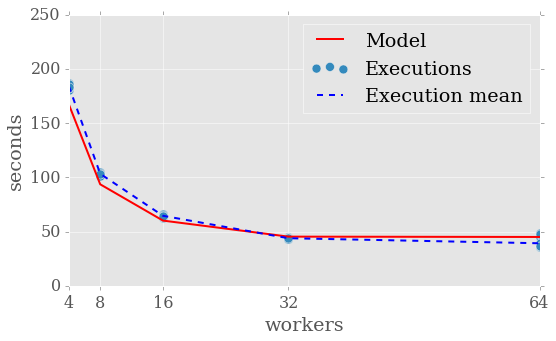

In [387]:
_prof = prof
_prof = _prof.groupby(['workers', 'input']).mean().reset_index()
_prof = get_extra_df(_prof, exp_info)
_target = get_extra_df(target, exp_info)
display(_prof)
display(_target.drop('ms', axis=1).drop_duplicates())

model = Model(LinearRegression())
model.fit(_prof)
linear = model.get_linreg()
display(linear.intercept_, linear.coef_)
display(model.score(_prof))
#plotter = Plotter()
#plotter.plot_model(model, _prof)

display(model.score(_target))
plotter = Plotter()
plotter.plot_model(model, _target)

In [379]:
coefs = model.get_linreg().coef_
cols = _prof.columns
val_var = [(coef, col) for coef, col in zip(coefs, cols)]
for value, var in sorted(val_var, key=lambda x: x[0]):
    print('{:f} {}'.format(value, var))

4.218936 iters_stg1_nf
296.300731 workers
3256.128070 iters_stg0_nf
